# Fine-tune SAM on customized datasets (2D example)
1. Prepare original 2D images `data/MedSAMDemo_2D/` (Download link:https://drive.google.com/file/d/18GhVEODbTi17jSeBXdeLQ7vHPdtlTYXK/view?usp=share_link) 
2. Run `pre_grey_rgb2D.py` for pre-processing. Expected output: `./data/demo2D_vit_b/demo2d.npz`
3. Start this fine-tuning tutorial

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import os
from cortex_percentage import calculate
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
import cv2

import torch
from torch import nn
from torch.autograd import Function
import torch.nn.functional as F


# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [10]:
# #%% create a dataset class to load npz data and return back image embeddings and ground truth
# class NpzDataset(Dataset): 
#     def __init__(self, data_root):
#         self.data_root = data_root
#         self.npz_files = sorted(os.listdir(self.data_root))
#         self.npz_data = [np.load(join(data_root, f)) for f in self.npz_files]
#         # this implementation is ugly but it works (and is also fast for feeding data to GPU) if your server has enough RAM
#         # as an alternative, you can also use a list of npy files and load them one by one
#         self.ori_gts = np.vstack([d['gts'] for d in self.npz_data])
#         self.img_embeddings = np.vstack([d['img_embeddings'] for d in self.npz_data])
#         print(f"{self.img_embeddings.shape=}, {self.ori_gts.shape=}")
        
#     def __len__(self):
#         return self.ori_gts.shape[0]

#     def __getitem__(self, index):
#         img_embed = self.img_embeddings[index]
#         gt2D = self.ori_gts[index]
#         y_indices, x_indices = np.where(gt2D > 0)
#         x_min, x_max = np.min(x_indices), np.max(x_indices)
#         y_min, y_max = np.min(y_indices), np.max(y_indices)
#         # add perturbation to bounding box coordinates
#         H, W = gt2D.shape
#         x_min = max(0, x_min - np.random.randint(0, 20))
#         x_max = min(W, x_max + np.random.randint(0, 20))
#         y_min = max(0, y_min - np.random.randint(0, 20))
#         y_max = min(H, y_max + np.random.randint(0, 20))
#         bboxes = np.array([x_min, y_min, x_max, y_max])
#         # convert img embedding, mask, bounding box to torch tensor
#         return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long(), torch.tensor(bboxes).float()

In [66]:
class NpzDataset(Dataset): 
    def __init__(self, npz_filename):
        self.npz_data = np.load(npz_filename)
        self.ori_gts = self.npz_data['gts']
        self.img_embeddings = self.npz_data['img_embeddings']
        print(f"{self.img_embeddings.shape=}, {self.ori_gts.shape=}")

    def __len__(self):
        return self.ori_gts.shape[0]

    def __getitem__(self, index):
        img_embed = self.img_embeddings[index]
        gt2D = self.ori_gts[index]
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bboxes = np.array([x_min, y_min, x_max, y_max])
        # convert img embedding, mask, bounding box to torch tensor
        return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long(), torch.tensor(bboxes).float()


In [12]:
# %% test dataset class and dataloader
npz_tr_path = 'data/demo2D_vit_b'
demo_dataset = NpzDataset(npz_tr_path)
demo_dataloader = DataLoader(demo_dataset, batch_size=8, shuffle=True)
for img_embed, gt2D, bboxes in demo_dataloader:
    #img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
    print(f"{img_embed.shape=}, {gt2D.shape=}, {bboxes.shape=}")
    break

PermissionError: [Errno 13] Permission denied: 'data/demo2D_vit_b'

In [67]:
ALPHA = 10
BETA = 0.75
GAMMA = 10.

class GradReverse(Function):
    lambd = 0

    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * GradReverse.lambd    

class DomainClassifier(nn.Module):
    """
    A wrapper for the run of encoder-rg-discriminator in order to run net in one
    back-propagation as described in paper.
    """
    def __init__(self, encoder, discriminator):
        super(DomainClassifier, self).__init__()
        self.encoder = encoder
        self.discriminator = discriminator
        self.lambd = 0

    def update_lambd(self, lambd):
        self.lambd = lambd
        GradReverse.lambd = self.lambd

    def forward(self, input):
        x = self.encoder(input)
        x = GradReverse.apply(x)
        x = self.discriminator(x)
        return x

In [68]:
class Classifier(nn.Module):
    """
    A classifier architecture for mnist data.
    """
    def __init__(self):
        super(Classifier, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # self.dense1 = nn.Linear(768, 100)
        # self.dense2 = nn.Linear(100, 100)
        # self.dense3 = nn.Linear(100, 10)

        # self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 256, kernel_size=8, stride=8) # Upsample to 256x256


    def forward(self, input):
        x = self.encode(input)
        # x = torch.flatten(x, start_dim=1)
        x = self.decode(x)
        return x

    def encode(self, input):
        # x = self.conv1(input)
        # x = F.relu(x)
        # x = self.max_pool(x)

        # x = self.conv2(x)
        # x = F.relu(x)
        # x = self.max_pool(x)
        # return x
        x = F.relu(self.conv1(input))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x

    def decode(self, input):
        # x = self.dense1(input)
        # x = F.relu(x)

        # x = self.dense2(x)
        # x = F.relu(x)

        # x = F.dropout(x, training=self.training)

        # x = self.dense3(x)
        # x = F.softmax(x, dim=1)
        # return x

        x = F.relu(self.upconv1(input))
        x = F.relu(self.dec_conv1(x))
        x = self.upconv2(x) # No activation, assuming a multi-class segmentation task
        
        return x

In [69]:
class Discriminator(nn.Module):
    """
    A discriminator architecture adapted for input feature maps with 64 channels.
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        # Convolutional Encoder
        self.conv1 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # Adjusted to 64 input channels
        self.conv2 = nn.Conv2d(128, 64, kernel_size=4, stride=2, padding=1)   # Output: 64 x 8 x 8
        self.conv3 = nn.Conv2d(64, 32, kernel_size=4, stride=2, padding=1)    # Output: 32 x 4 x 4

        # Flatten and Dense Layers
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(128, 100)  # Adjusted to match the new flattened conv output
        self.dense2 = nn.Linear(100, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        # Convolutional layers
        x = F.leaky_relu(self.conv1(input))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))

        # Flatten and dense layers
        x = self.flatten(x)
        x = self.relu(self.dense1(x))
        x = self.dense2(x)
        x = self.sigmoid(x)
        return x


In [102]:
class GRDomainAdaptation:

    def __init__(self):
        ###########################
        # Initialize Info Holders #
        ########################### 
        # self.args = get_params(source_dataset, experiment='adaptation')
        self.source_dataset = 'mnist'
        self.target_dataset = 'mnist_m'
        self.n_epochs = 50
        self.batch_size_train = 64
        self.batch_size_test = 1000
        self.learning_rate = 0.01
        self.momentum = 0.9
        self.log_interval = 10

        self.random_seed = 1
        self.cuda = True
        self.check_pth = '/home/ubuntu/nadav/GradientReversal/weights/mnist2mnist_m'


        self.source_best_pred = 0.0
        self.target_best_pred = 0.0
        self.best_source_net_state = None
        self.best_target_net_state = None
        self.source_test_losses = []
        self.target_test_losses = []
        self.source_test_acc = []
        self.target_test_acc = []
        self.iters = 0

        #######################################
        # Initialize Source and target labels #
        #######################################
        self.source_disc_labels = torch.zeros(size=(self.batch_size_train, 1)).requires_grad_(False)
        self.target_disc_labels = torch.ones(size=(self.batch_size_train, 1)).requires_grad_(False)
        if self.cuda:
            self.source_disc_labels = self.source_disc_labels.cuda()
            self.target_disc_labels = self.target_disc_labels.cuda()

        """
        First preprocess the source data into a .npz file under data/demo2D_vit_b using pre_grey_gbr2D.py and give it a distinct file name.
        Then run NpzDataset giving it the filename of the .npz file. Do all of this again for our target data (preprocess, give it a 
        distinct name, then run NpzDataset giving it the filename (ex: NpzDataset('data/demo_2D_vit_b/target_data.npz')))
        """

        self.source_dataset = NpzDataset('data/demo2D_vit_b/source_dataset.npz')
        self.target_dataset = NpzDataset('data/demo2D_vit_b/target_dataset.npz')

        self.source_train_loader = DataLoader(self.source_dataset, batch_size=8, shuffle=True)
        self.target_train_loader = DataLoader(self.target_dataset, batch_size=8, shuffle=True)

        # self.source_test_loader = 
        # self.target_test_loader = 

        self.n_batch = min(len(self.target_train_loader), len(self.source_train_loader))

        ##################
        # Define network #
        ##################
        self.net = Classifier()

        if self.cuda:
            self.net = torch.nn.DataParallel(self.net, device_ids=[0])
            self.net = self.net.cuda()

        ###############
        # Set Encoder #
        ###############
        if self.cuda:
            self.encoder = self.net.module.encode
        else:
            self.encoder = self.net.encode

        device = 'cuda:0'
        checkpoint = 'work_dir/SAM/sam_vit_b_01ec64.pth'
        model_type = 'vit_b'        
        self.net = sam_model_registry[model_type](checkpoint=checkpoint).to(device)


        ###################################################
        # Set Domain Classifier (Encoder + Discriminator) #
        ###################################################
        self.discriminator = Discriminator()
        self.domain_classifier = DomainClassifier(self.encoder, self.discriminator)
        if self.cuda:
            self.domain_classifier = torch.nn.DataParallel(self.domain_classifier, device_ids=[0])
            self.domain_classifier = self.domain_classifier.cuda()

        #####################
        # Define Optimizers #
        #####################
        self.net_optimizer = torch.optim.Adam(self.net.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
        self.encoder_optimizer = torch.optim.SGD(self.net.parameters(), self.learning_rate, momentum=self.momentum)
        self.discriminator_optimizer = torch.optim.SGD(self.discriminator.parameters(), lr=self.learning_rate, momentum=self.momentum)

    def train_epoch(self):
        
        self.net.train()
        tbar = tqdm(enumerate(zip(self.source_train_loader, self.target_train_loader)))
        net_loss = 0.0
        disc_loss = 0.0
        total_loss = 0.0

        for i, ((image_embedding, gt2D, boxes), (target_img, _, _)) in enumerate((zip(self.source_train_loader, self.target_train_loader))):
            ##############################
            # update learning parameters #
            ##############################
            print(i)
            self.iters += 1
            p = self.iters / (self.n_epochs * self.n_batch)

            lambd = (2. / (1. + np.exp(-GAMMA * p))) - 1
            if self.cuda:
                self.domain_classifier.module.update_lambd(lambd)
            else:
                self.domain_classifier.update_lambd(lambd)

            lr = self.learning_rate / (1. + ALPHA * p) ** BETA
            self.discriminator_optimizer.lr = lr
            self.net_optimizer.lr = lr
            self.encoder_optimizer.lr = lr

            #########################################################################
            # set batch size in cases where source and target domain differ in size #
            #########################################################################
            curr_batch_size = min(image_embedding.shape[0], target_img.shape[0])
            # image_embedding = image_embedding[:curr_batch_size]
            # gt2D = gt2D[:curr_batch_size]
            # target_img = target_img[:curr_batch_size]
            source_disc_labels = self.source_disc_labels[:curr_batch_size]
            target_disc_labels = self.target_disc_labels[:curr_batch_size]
            if self.cuda:
                image_embedding, gt2D = image_embedding.cuda(), gt2D.cuda()
                target_img = target_img.cuda()

            #######################################################
            # Train network (Encoder + Classifier) on Source Data #
            #######################################################
            device = 'cuda:0'
            with torch.no_grad():
                # convert box to 1024x1024 grid
                box_np = boxes.numpy()
                sam_trans = ResizeLongestSide(self.net.image_encoder.img_size)
                box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
                box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
                if len(box_torch.shape) == 2:
                    box_torch = box_torch[:, None, :] # (B, 1, 4)
                # get prompt embeddings 
                sparse_embeddings, dense_embeddings = self.net.prompt_encoder(
                    points=None,
                    boxes=box_torch,
                    masks=None,
                )

            
            # net_output = self.net(source_img)

            net_output, _ = self.net.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=self.net.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )
            seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
            class_net_loss = seg_loss(net_output, gt2D.to(device))
            self.net_optimizer.zero_grad()
            class_net_loss.backward()
            self.net_optimizer.step()
            net_loss += class_net_loss

            #########################################
            # Train encoder on Source + Target data #
            #########################################
            self.encoder_optimizer.zero_grad()
            self.discriminator_optimizer.zero_grad()
            dom_input = torch.cat([image_embedding, target_img], dim=0)
            dom_labels = torch.cat([source_disc_labels, target_disc_labels], dim=0)
            dom_output = self.domain_classifier(dom_input)
            dom_loss = F.binary_cross_entropy(dom_output, dom_labels)

            # calculate total loss value
            dom_loss.backward()
            self.discriminator_optimizer.step()
            self.encoder_optimizer.step()
            disc_loss += dom_loss

            total_loss += class_net_loss - lambd * dom_loss
            tbar.set_description('Net loss: {0:.6f}; Discriminator loss: {1:.6f}; Total Loss: {2:.6f}; {3:.2f}%;'.format((net_loss / (i + 1)),
                                                                                                                         (disc_loss / (i + 1)),
                                                                                                                         (total_loss / (i + 1)),
                                                                                                                        (i + 1) / self.n_batch * 100))
        
    def train(self):
        for epoch in range(self.n_epochs):
            print('Epoch: {}; Source Best: {}; Target Best: {}'.format(epoch, self.source_best_pred, self.target_best_pred))
            self.train_epoch()
            # self.test_net()
        output_dir = 'output_dir/'
        os.makedirs(output_dir, exist_ok=True)
        # self.plot_acc_info(output_dir)
        torch.save(self.best_source_net_state, os.path.join(output_dir, 'source_model.pth'))
        torch.save(self.best_target_net_state, os.path.join(output_dir, 'target_model.pth'))



# https://github.com/Nadavc220/Domain-Adversarial-Training-of-Neural-Networks-pytorch/blob/master/train_adaptation.py

trainer = GRDomainAdaptation()
trainer.train()

self.img_embeddings.shape=(456, 256, 64, 64), self.ori_gts.shape=(456, 256, 256)
self.img_embeddings.shape=(69, 256, 64, 64), self.ori_gts.shape=(69, 256, 256)
Epoch: 0; Source Best: 0.0; Target Best: 0.0


0


1


2


3


4


5


6


7


8


Net loss: 0.270334; Discriminator loss: 0.693254; Total Loss: 0.235723; 88.89%;: : 0it [39:03, ?it/s]
Net loss: 0.273225; Discriminator loss: 0.693145; Total Loss: 0.238620; 88.89%;: : 0it [38:00, ?it/s]
Net loss: 0.288664; Discriminator loss: 0.693954; Total Loss: 0.254019; 88.89%;: : 0it [32:13, ?it/s]
Net loss: 0.257967; Discriminator loss: 0.693316; Total Loss: 0.223353; 88.89%;: : 0it [25:38, ?it/s]
Net loss: 0.269419; Discriminator loss: 0.693477; Total Loss: 0.234797; 88.89%;: : 0it [24:34, ?it/s]
0it [18:53, ?it/s]
Net loss: 0.288659; Discriminator loss: 0.693181; Total Loss: 0.254051; 88.89%;: : 0it [16:41, ?it/s]


ValueError: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([13, 1])) is deprecated. Please ensure they have the same size.

In [92]:
trainer = GRDomainAdaptation()
trainer.train()

self.img_embeddings.shape=(456, 256, 64, 64), self.ori_gts.shape=(456, 256, 256)
self.img_embeddings.shape=(69, 256, 64, 64), self.ori_gts.shape=(69, 256, 256)
Epoch: 0; Source Best: 0.0; Target Best: 0.0




















8it [00:13,  1.63s/it]


RuntimeError: The size of tensor a (40) must match the size of tensor b (8) at non-singleton dimension 0

In [72]:
# %% set up model for fine-tuning 
# train data path
npz_tr_path = 'data/demo2D_vit_b'
work_dir = './work_dir'
task_name = 'demo2D'
# prepare SAM model
model_type = 'vit_b'
checkpoint = 'work_dir/SAM/sam_vit_b_01ec64.pth'
device = 'cuda:0'
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True)
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model.train()
# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [93]:

#%% train
num_epochs = 200
losses = []
best_loss = 1e10
# train_dataset = NpzDataset(npz_tr_path)
# train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

source_dataset = NpzDataset('data/demo2D_vit_b/source_dataset.npz')
target_dataset = NpzDataset('data/demo2D_vit_b/target_dataset.npz')

source_train_loader = DataLoader(source_dataset, batch_size=8, shuffle=True)
target_train_loader = DataLoader(target_dataset, batch_size=8, shuffle=True)
tbar = tqdm(enumerate(zip(target_train_loader, source_train_loader)))

for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    # for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(target_train_loader)):
    for step, ((image_embedding, gt2D, boxes), (_,_,_)) in enumerate(tqdm(zip(source_train_loader, target_train_loader))):

        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))

self.img_embeddings.shape=(456, 256, 64, 64), self.ori_gts.shape=(456, 256, 256)
self.img_embeddings.shape=(69, 256, 64, 64), self.ori_gts.shape=(69, 256, 256)




0it [34:52, ?it/s]










9it [00:05,  1.65it/s]


EPOCH: 0, Loss: 0.12778515927493572












9it [00:05,  1.78it/s]


EPOCH: 1, Loss: 0.1599353589117527












9it [00:04,  1.81it/s]


EPOCH: 2, Loss: 0.14055332820862532












9it [00:04,  1.81it/s]


EPOCH: 3, Loss: 0.12288977950811386












9it [00:05,  1.78it/s]


EPOCH: 4, Loss: 0.11061186715960503












9it [00:05,  1.68it/s]


EPOCH: 5, Loss: 0.1049943994730711












9it [00:05,  1.73it/s]


EPOCH: 6, Loss: 0.11593618337064981












9it [00:05,  1.79it/s]


EPOCH: 7, Loss: 0.1062548654153943












9it [00:04,  1.82it/s]


EPOCH: 8, Loss: 0.1060287756845355












9it [00:04,  1.83it/s]


EPOCH: 9, Loss: 0.11200320161879063












9it [00:05,  1.79it/s]


EPOCH: 10, Loss: 0.09664511866867542












9it [00:04,  1.81it/s]


EPOCH: 11, Loss: 0.11524263583123684












9it [00:04,  1.83it/s]


EPOCH: 12, Loss: 0.13557720184326172












9it [00:04,  1.81it/s]


EPOCH: 13, Loss: 0.10426212288439274












9it [00:05,  1.79it/s]


EPOCH: 14, Loss: 0.12863431591540575












9it [00:05,  1.74it/s]


EPOCH: 15, Loss: 0.1009442862123251












9it [00:05,  1.73it/s]


EPOCH: 16, Loss: 0.10169312730431557












9it [00:05,  1.72it/s]


EPOCH: 17, Loss: 0.08762767072767019












9it [00:05,  1.67it/s]


EPOCH: 18, Loss: 0.08961294684559107












9it [00:05,  1.69it/s]


EPOCH: 19, Loss: 0.08885931316763163












9it [00:05,  1.76it/s]


EPOCH: 20, Loss: 0.08651976939290762












9it [00:05,  1.75it/s]


EPOCH: 21, Loss: 0.08638791833072901












9it [00:05,  1.79it/s]


EPOCH: 22, Loss: 0.10720161255449057












9it [00:04,  1.81it/s]


EPOCH: 23, Loss: 0.0891467398032546












9it [00:05,  1.78it/s]


EPOCH: 24, Loss: 0.09413687326014042












9it [00:05,  1.76it/s]


EPOCH: 25, Loss: 0.08512469846755266












9it [00:05,  1.78it/s]


EPOCH: 26, Loss: 0.09435408841818571












9it [00:05,  1.75it/s]


EPOCH: 27, Loss: 0.09615743346512318












9it [00:04,  1.81it/s]


EPOCH: 28, Loss: 0.09924075193703175












9it [00:04,  1.81it/s]


EPOCH: 29, Loss: 0.07885325700044632












9it [00:04,  1.81it/s]


EPOCH: 30, Loss: 0.09671442583203316












9it [00:05,  1.77it/s]


EPOCH: 31, Loss: 0.1045385254547












9it [00:05,  1.77it/s]


EPOCH: 32, Loss: 0.09762727189809084












9it [00:05,  1.79it/s]


EPOCH: 33, Loss: 0.09181664511561394












9it [00:04,  1.81it/s]


EPOCH: 34, Loss: 0.09496696852147579












9it [00:05,  1.79it/s]


EPOCH: 35, Loss: 0.10306561645120382












9it [00:05,  1.77it/s]


EPOCH: 36, Loss: 0.0941107701510191












9it [00:05,  1.79it/s]


EPOCH: 37, Loss: 0.07724149711430073












9it [00:04,  1.80it/s]


EPOCH: 38, Loss: 0.0871299346908927












9it [00:05,  1.79it/s]


EPOCH: 39, Loss: 0.10524960700422525












9it [00:05,  1.79it/s]


EPOCH: 40, Loss: 0.08322286978363991












9it [00:04,  1.82it/s]


EPOCH: 41, Loss: 0.09866865631192923












9it [00:04,  1.81it/s]


EPOCH: 42, Loss: 0.09641831181943417












9it [00:05,  1.79it/s]


EPOCH: 43, Loss: 0.08315713331103325












9it [00:04,  1.81it/s]


EPOCH: 44, Loss: 0.1065711472183466












9it [00:04,  1.81it/s]

EPOCH: 45, Loss: 0.09351977054029703


KeyboardInterrupt: 

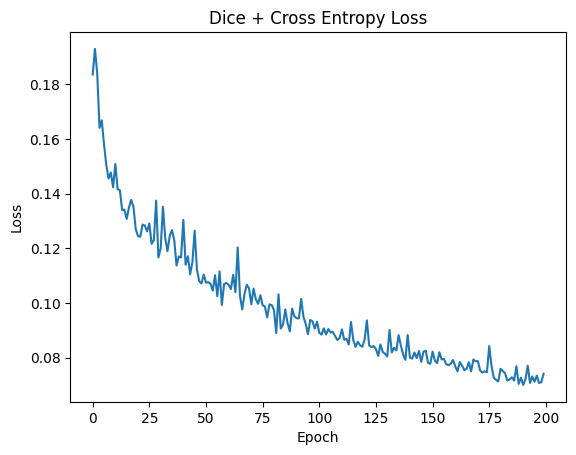

In [19]:
# plot loss
plt.plot(losses)
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.close()

In [7]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
from skimage import io
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)

ts_img_path = 'data/MedSAMDemo_2D/test/images'
ts_gt_path = 'data/MedSAMDemo_2D/test/labels'
test_names = sorted(os.listdir(ts_img_path))

# random select a test case
img_idx = np.random.randint(len(test_names))
image_data = io.imread(join(ts_img_path, test_names[img_idx]))
if image_data.shape[-1]>3 and len(image_data.shape)==3:
    image_data = image_data[:,:,:3]
if len(image_data.shape)==2:
    image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
# read ground truth (gt should have the same name as the image) and simulate a bounding box
def get_bbox_from_mask(mask):
    
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

# gt_data = io.imread(join(ts_gt_path, test_names[img_idx]))
# bbox_raw = get_bbox_from_mask(gt_data)


# preprocess: cut-off and max-min normalization
lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
image_data_pre = np.clip(image_data, lower_bound, upper_bound)
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre[image_data==0] = 0
image_data_pre = np.uint8(image_data_pre)
H, W, _ = image_data_pre.shape

# predict the segmentation mask using the original SAM model
ori_sam_predictor.set_image(image_data_pre)
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=None, multimask_output=False)

In [16]:
# predict the segmentation mask using the fine-tuned model
# resize image to 3*1024*1024

# sam_model.load_state_dict(torch.load('work_dir/SAM/sam_vit_b_01ec64.pth'))
# sam_model.eval()

sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
resize_img = sam_transform.apply_image(image_data_pre)
resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'

with torch.no_grad():
    # pre-compute the image embedding
    ts_img_embedding = sam_model.image_encoder(input_image)
    # convert box to 1024x1024 grid
    # bbox = sam_trans.apply_boxes(bbox_raw, (H, W))
    # print(f'{bbox_raw=} -> {bbox=}')
    # box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
    
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4) #My code for not showing the bbox
    
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    medsam_seg_prob, _ = sam_model.mask_decoder(
        image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    print(medsam_seg.shape)

(256, 256)


In [15]:
# ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)
# medsam_dsc = compute_dice_coefficient(gt_data>0, medsam_seg>0)
# print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))

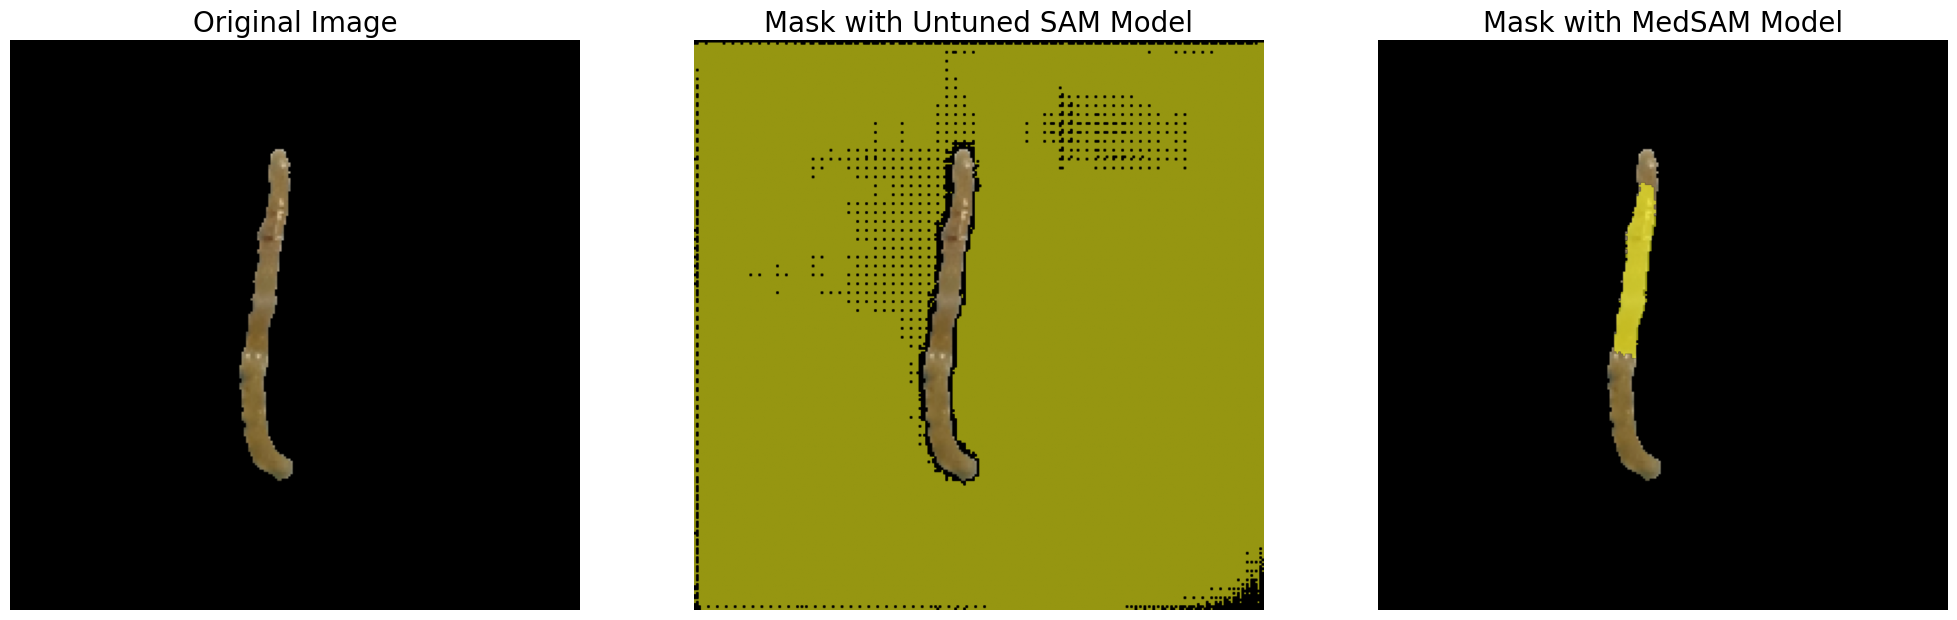

segmented cortex: 808
sample pixels: 1558
ratio: 0.5186136071887034


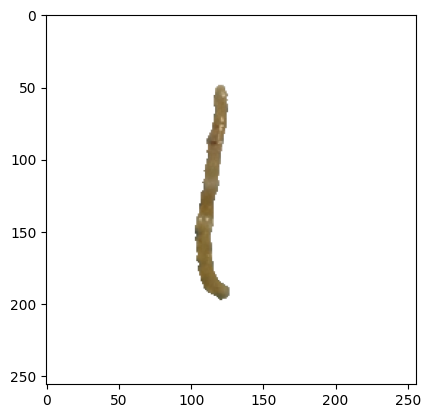

In [17]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    


_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(image_data)

# show_mask(gt_data>0, axs[0])
# show_box(box_np[img_id], axs[0])
axs[0].set_title('Original Image', fontsize=20)
axs[0].axis('off')

axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
# show_box(bbox_raw, axs[1])
# add text to image to show dice score
# axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='blue')
axs[1].set_title('Mask with Untuned SAM Model', fontsize=20)
axs[1].axis('off')

axs[2].imshow(image_data)
show_mask(medsam_seg, axs[2])
# show_box(bbox_raw, axs[2])
# add text to image to show dice score
# axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='blue')
axs[2].set_title('Mask with MedSAM Model', fontsize=20)
axs[2].axis('off')
plt.savefig('output_image.png', bbox_inches='tight', dpi=300)
plt.show()  

plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()

#nonblack_pixels = np.sum(np.any(image_data[:, :, :3] > 0, axis=2))
#print("Non-black pixels:", nonblack_pixels)

overlay = image_data.copy()
overlay[medsam_seg > 0] = [0, 255, 0]

# Save the overlaid image as a JPEG file
cv2.imwrite("image_with_mask.png", overlay)
image = cv2.imread("image_with_mask.png")



def count_green_pixels(image, green_threshold=(0, 255, 0)):
    """
    Count the number of green pixels in the input image.

    Parameters:
        image (numpy array): Input image in RGB format (H x W x 3).
        green_threshold (tuple): Threshold for green color in the RGB color space.
                                 Default is (0, 255, 0) for pure green color.

    Returns:
        int: Number of green pixels in the image.
    """
    # Define the lower and upper bounds for green color in the RGB color space
    lower_bound = np.array(green_threshold, dtype=np.uint8)
    upper_bound = np.array(green_threshold, dtype=np.uint8)

    # Extract green pixels within the specified color range
    green_mask = cv2.inRange(image, lower_bound, upper_bound)

    # Count the number of green pixels
    num_green_pixels = np.sum(green_mask > 0)

    return num_green_pixels

# Assuming you already have loaded the image_data (H x W x 3)

# Set the green threshold (adjust as needed)
green_threshold = (0, 255, 0)

# Count the number of green pixels in the image_data
num_green_pixels = count_green_pixels(image_data, green_threshold)

def calculate(input, segmentation):
    import numpy as np
    import matplotlib.pyplot as plt

    segmented = np.sum(segmentation > 0)
    print("segmented cortex:", segmented)


    threshold = 50  # Adjust this value based on your preference

    # Remove black or very dark gray pixels
    image_without_dark = image_data.copy()
    gray_intensity = np.sum(image_data, axis=-1) // 3  # Convert RGB to grayscale
    image_without_dark[gray_intensity <= threshold] = [255, 255, 255]
    plt.imshow(image_without_dark)

    grayscale_image = np.sum(image_without_dark, axis=-1) // 3

    # Count non-white pixels
    non_white_pixels = np.sum(grayscale_image < 255)

    print("sample pixels:", non_white_pixels)
    print("ratio:", segmented/(non_white_pixels))

calculate(image_data, medsam_seg)

